In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

# helper functions
sys.path.insert(0, "../src/lib")

import dataset as dataset_funcs
import cleaning as cleaning_funcs

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
sales_df = pd.read_csv('../data/raw/sales.csv')
sales_df.DATE_ORDER = sales_df.DATE_ORDER.astype("datetime64")
sales_df["UNIT_PRICE"] = sales_df["REVENUE"] / sales_df["QTY_ORDER"]
sales_df.sample(5)

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,UNIT_PRICE
140805,P7,2015-09-09,1.000,699.000,699.000
281152,P8,2015-10-08,1.000,394.900,394.900
177667,P7,2015-06-16,1.000,749.000,749.000
212719,P2,2015-01-19,1.000,829.000,829.000
176203,P7,2015-07-14,1.000,749.000,749.000


as we mentioned on the **EXPLORATORY DATA ANALYSIS**, we will remove some bad data from our dataset to avoid propagating these errors to the model (using helper functions).

In [3]:
sales_df = cleaning_funcs.clean_sales_dataframe(sales_df)
sales_df.shape

(351090, 5)

let's split the data into each product (because each product may have different dynamics)

In [4]:
group_ids = ['P1','P2','P3','P4','P5','P6','P7','P8','P9']
grouped = sales_df.groupby([sales_df.PROD_ID])
(p1,p2,p3,p4,p5,p6,p7,p8,p9) = [grouped.get_group(prod_id) for prod_id in group_ids]

let's use P7 in the first run because it's the product the with the most available data

In [5]:
p7 = p7.sort_values(['DATE_ORDER'])

In [6]:
# now just select the columns we will use in this very simple model
p7 = p7[["UNIT_PRICE","QTY_ORDER"]]

In [7]:
X,y = dataset_funcs.make_Xy_simple(p7)

In [8]:
X.shape,y.shape

((195938, 1), (195938,))

For the first approach I will use a simple linear model (linear regression) without regularization. We'll apply a simple K-fold cross validation, with 8 folds.

In [17]:
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_absolute_error

In [10]:
kf = KFold(n_splits=8)

# I think MAE (mean absolute error) is easier to interpret than MSE (mean squared error)
MAES = []
COEFS = []
INTERCEPTS = []

regr = LinearRegression()
regr.fit(X,y)

MAE = mean_absolute_error(y,regr.predict(y.reshape(-1,1)))

print("MAE for cross validated model: {0}".format(MAE))

MAE for cross validated model: 0.4455219321585213


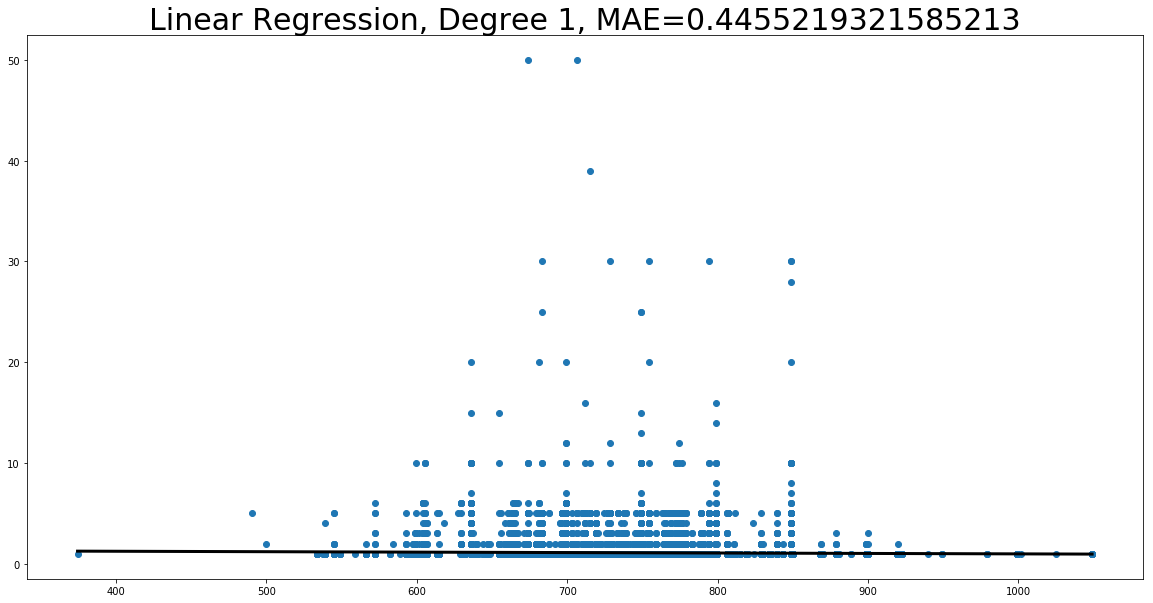

In [11]:
xs = np.linspace(X.min(),X.max(),1000)
ys = regr.predict(xs.reshape(-1,1))
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X,y)
ax.plot(xs,ys, 'k', lw=3)
plt.title("Linear Regression, Degree 1, MAE={0}".format(MAE),size=30)

comment: regression doesn't look like a good strategy here. But before trying a classification approach, let's try and use a General Linear Model (i.e. induce non-linear features) to see if we can get better results.

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [13]:
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

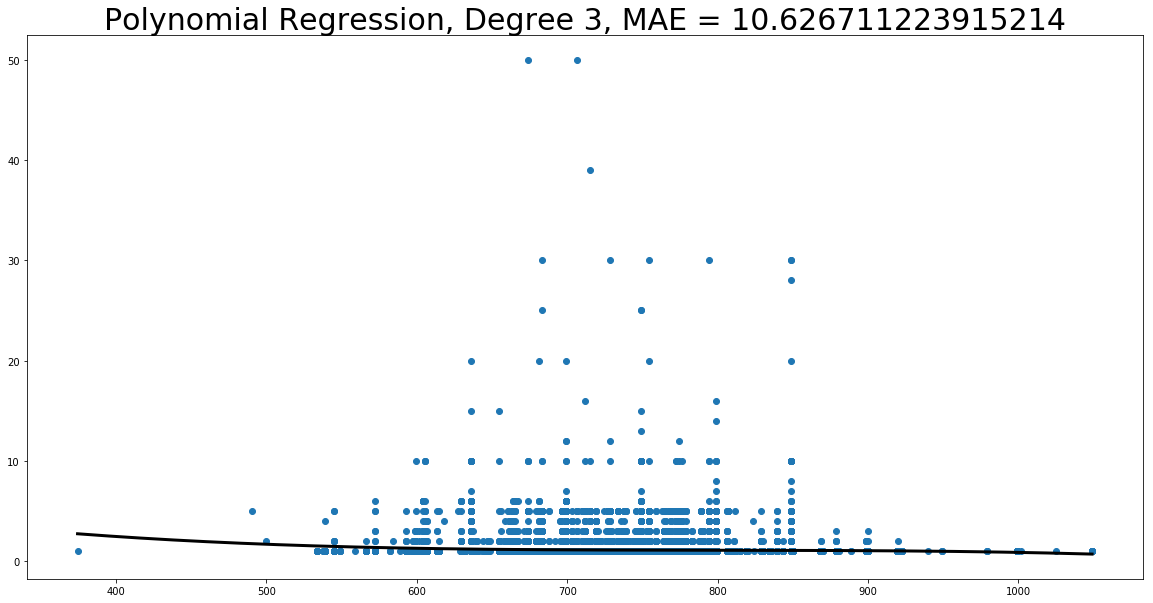

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X.reshape(1,-1),y)
xs = np.linspace(X.min(),X.max(), 1000)
ys = model.predict(xs.reshape(-1,1))
plt.plot(xs, ys,'k' , linewidth=3)

MAE = mean_absolute_error(y,model.predict(y.reshape(-1,1)))

plt.title("Polynomial Regression, Degree 3, MAE = {0}".format(MAE),size=30)

comment: doesn't look like it's made much difference.

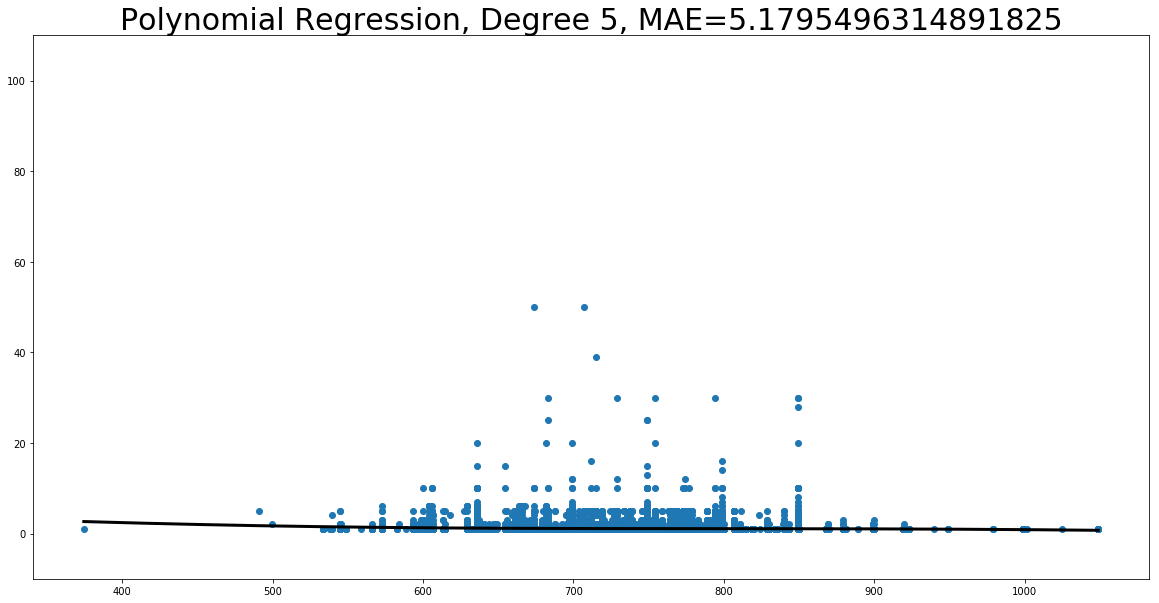

In [15]:
model = make_pipeline(PolynomialFeatures(5), LinearRegression())
model.fit(X, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X,y)
xs = np.linspace(X.min(), X.max(), 1000)
ys = model.predict(xs.reshape(-1,1))
MAE = mean_absolute_error(y,model.predict(y.reshape(-1,1)))
plt.plot(xs, ys,'k' , linewidth=3)
plt.ylim((-10,110))
plt.title("Polynomial Regression, Degree 5, MAE={0}".format(MAE),size=30)

comment: again, no big improvement.